# Tratamiento de los datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
import pandas as pd
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import NearestNeighbors

import geopandas as gpd
from shapely.geometry import Point
from scipy.optimize import minimize



In [2]:
# Estilo gráfico
sns.set(style="whitegrid")

In [3]:
# Importar datos

#dim_tienda = pd.read_csv("/Users/abigail/Desktop/SEM VIII/DSC/Data/DIM_TIENDA.csv")
#venta = pd.read_csv("/Users/abigail/Desktop/SEM VIII/DSC/Data/Venta.csv")
#meta_venta = pd.read_csv("/Users/abigail/Desktop/SEM VIII/DSC/Data/Meta_venta.csv")

In [4]:
# Merge de datasets
#df = venta.merge(dim_tienda, on="TIENDA_ID", how="left")
#df = df.merge(meta_venta, on="ENTORNO_DES", how="left")


In [5]:
# Crear variable target
#df["EXITO"] = (df["VENTA_TOTAL"] >= df["Meta_venta"]).astype(int)

In [6]:
# Mostrar estructura del dataframe final
df = pd.read_csv("/Users/abigail/Desktop/SEM VIII/DSC/Data/COMPLETE.csv")

| **table**    | **title**                  | **type** | **description** |
|--------------|----------------------------|----------|-----------------|
| DIM_TIENDA   | TIENDA_ID                  | string   | Hace referencia al código que se utiliza para identificar una tienda |
| DIM_TIENDA   | PLAZA_CVE                  | string   | Hace referencia al nombre de la plaza donde está asignada la tienda |
| DIM_TIENDA   | NIVELSOCIOECONOMICO_DES    | string   | Hace referencia al promedio del nivel socioeconómico del entorno en que se ubica la tienda |
| DIM_TIENDA   | ENTORNO_DES                | string   | Hace referencia al entorno en que se ubica la tienda |
| DIM_TIENDA   | MTS2VENTAS_NUM             | float    | Hace referencia a la medida del área del piso de ventas en la tienda y cuarto frío de exhibición al cliente, expresado en metros cuadrados (m²) |
| DIM_TIENDA   | PUERTASREFRIG_NUM          | float    | Hace referencia al número de puertas del cuarto frío |
| DIM_TIENDA   | CAJONESESTACIONAMIENTO_NUM | float    | Hace referencia a la cantidad de cajones de estacionamiento de la tienda |
| DIM_TIENDA   | LATITUD_NUM                | float    | Hace referencia a la latitud de la tienda |
| DIM_TIENDA   | LONGITUD_NUM               | float    | Hace referencia a la longitud de la tienda |
| DIM_TIENDA   | SEGMENTO_MAESTRO_DESC      | string   | Hace referencia al tipo de segmento al que pertenece la tienda |
| DIM_TIENDA   | LID_UBICACION_TIENDA       | string   | Hace referencia al tipo de ubicación de la tienda |
| DIM_TIENDA   | Dataset                    | string   | Hace referencia al conjunto al que pertenece la tienda: TRAIN o TEST |
| Venta        | TIENDA_ID                  | string   | Hace referencia al código que se utiliza para identificar una tienda |
| Venta        | MES_ID                     | string   | Hace referencia al año y mes |
| Venta        | VENTA_AMT                  | float    | Hace referencia a la venta mensual de la tienda |
| Meta_Venta   | ENTORNO_DES                | string   | Hace referencia al entorno en que se ubica la tienda |
| Meta_Venta   | Meta_venta                 | float    | Hace referencia a la venta mensual requerida para alcanzar su meta de venta |
| -   | EXITO                      | float    | Indica si la tienda alcanzó o no la meta de venta mensual (1 = sí, 0 = no) |
| DEMO   | POBTOT                     | float    | Total de personas que residen habitualmente en las viviendas particulares del AGEB |
| DEMO   | TOTHOG                     | float    | Hogares en viviendas particulares habitadas. Se considera hogar a una o más personas que comparten el gasto de alimentación |
| DEMO   | POCUPADA                   | float    | Personas de 12 a 130 años de edad que trabajaron o tuvieron empleo durante la semana anterior al censo |
| DEMO  | PDESOCUP                   | float    | Personas de 12 a 130 años de edad que no tenían trabajo pero buscaron uno durante la semana anterior al censo |
| DEMO   | P_18A24                    | float    | Personas de 18 a 24 años de edad |
| DEMO   | P_18A24_F                  | float    | Mujeres de 18 a 24 años de edad |
| DEMO   | P_18A24_M                  | float    | Hombres de 18 a 24 años de edad |
| DEMO  | VPH_REFRI                  | float    | Viviendas particulares habitadas que tienen refrigerador |
| DEMO   | VPH_AUTOM                  | float    | Viviendas particulares habitadas que tienen automóvil o camioneta |
| DEMO  | VPH_PC                     | float    | Viviendas particulares habitadas que tienen computadora |
| DEMO   | VPH_NDACMM                 | float    | Viviendas particulares habitadas que no disponen de ningún bien de las TIC o automotor |
| DEMO   | VPH_SINCINT                | float    | Viviendas particulares habitadas que no cuentan con conexión a internet |
| DEMO   | P_12YMAS                   | float    | Personas de 12 a 130 años de edad |
| DEMO   | P_15YMAS                   | float    | Personas de 15 a 130 años de edad |
| DEMO   | P_15A49_F                  | float    | Mujeres de 15 a 49 años de edad |
| DEMO   | POB15_64                   | float    | Personas de 15 a 64 años de edad |
| DEMO   | PEA                        | float    | Personas de 12 a 130 años de edad que trabajaron o buscaron trabajo |
| DEMO   | PE_INAC                    | float    | Personas de 12 a 130 años de edad pensionadas, jubiladas, estudiantes, dedicadas a quehaceres del hogar, etc. |
| DEMO   | P12YM_CASA                 | float    | Personas de 12 a 130 años de edad casadas sólo por lo civil o por la iglesia |
| DEMO   | P12YM_SOLT                 | float    | Personas de 12 a 130 años de edad solteras |
| DEMO   | P15YM_AN                   | float    | Personas de 15 a 130 años de edad que no saben leer ni escribir |
| DEMO   | P15YM_SE                   | float    | Personas de 15 a 130 años de edad que no aprobaron algún grado escolar |
| DEMO   | P15PRI_CO                  | float    | Personas de 15 a 130 años de edad que tienen completa la primaria |
| DEMO   | P15SEC_CO                  | float    | Personas de 15 a 130 años de edad que tienen completa la secundaria |
| DEMO   | P18YM_PB                   | float    | Personas de 18 a 130 años de edad que tienen al menos un grado aprobado de nivel profesional |

In [7]:
df

,TIENDA_ID,MES_ID,VENTA_TOTAL,PLAZA_CVE,NIVELSOCIOECONOMICO_DES,ENTORNO_DES,MTS2VENTAS_NUM,PUERTASREFRIG_NUM,CAJONESESTACIONAMIENTO_NUM,LATITUD_NUM,...,POB15_64,PEA,PE_INAC,P12YM_CASA,P12YM_SOLT,P15YM_AN,P15YM_SE,P15PRI_CO,P15SEC_CO,P18YM_PB
0,813,202404,1042761.16,2.0,C,Hogar,108.360000,12.0,0.0,25.99200,...,2162.0,1553.0,1069.0,1292.0,864.0,82.0,131.0,433.0,626.0,835.0
1,436,202404,2486787.81,3.0,BC,Hogar,111.437652,13.0,0.0,25.54982,...,904.0,644.0,359.0,606.0,339.0,12.0,13.0,56.0,181.0,615.0
2,732,202404,680701.78,5.0,C,Hogar,118.460000,15.0,0.0,25.75866,...,7080.0,5378.0,2102.0,5192.0,1892.0,31.0,33.0,441.0,2772.0,3370.0
3,282,202404,1227768.82,6.0,BC,Receso,114.000000,13.0,0.0,24.85018,...,2298.0,1516.0,1551.0,1586.0,1047.0,46.0,57.0,331.0,546.0,1441.0
4,704,202404,1052094.97,1.0,C,Base,107.230000,13.0,0.0,25.68419,...,3258.0,2376.0,1844.0,1954.0,1522.0,85.0,121.0,483.0,1062.0,1792.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18569,233,202312,395789.12,4.0,C,Base,102.970000,13.0,10.0,25.66750,...,6716.0,4924.0,3120.0,4188.0,2749.0,117.0,186.0,863.0,2079.0,3521.0
18570,539,202312,1413451.87,6.0,B,Base,114.815000,13.0,0.0,25.69036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18571,885,202312,1157010.83,2.0,B,Receso,110.150000,10.0,9.0,25.98226,...,968.0,749.0,592.0,666.0,404.0,8.0,3.0,101.0,96.0,939.0
18572,793,202401,699916.91,6.0,C,Base,109.400000,13.0,0.0,25.19030,...,1635.0,1241.0,933.0,1022.0,721.0,47.0,108.0,250.0,499.0,839.0


In [8]:
list(df.columns)

['TIENDA_ID',
 'MES_ID',
 'VENTA_TOTAL',
 'PLAZA_CVE',
 'NIVELSOCIOECONOMICO_DES',
 'ENTORNO_DES',
 'MTS2VENTAS_NUM',
 'PUERTASREFRIG_NUM',
 'CAJONESESTACIONAMIENTO_NUM',
 'LATITUD_NUM',
 'LONGITUD_NUM',
 'SEGMENTO_MAESTRO_DESC',
 'LID_UBICACION_TIENDA',
 'DATASET',
 'Meta_venta',
 'EXITO',
 'POBTOT',
 'TOTHOG',
 'POCUPADA',
 'PDESOCUP',
 'P_18A24',
 'P_18A24_F',
 'P_18A24_M',
 'VPH_REFRI',
 'VPH_AUTOM',
 'VPH_PC',
 'VPH_NDACMM',
 'VPH_SINCINT',
 'P_12YMAS',
 'P_15YMAS',
 'P_15A49_F',
 'POB15_64',
 'PEA',
 'PE_INAC',
 'P12YM_CASA',
 'P12YM_SOLT',
 'P15YM_AN',
 'P15YM_SE',
 'P15PRI_CO',
 'P15SEC_CO',
 'P18YM_PB']

# EDA

## Unicas Tiendas Agrupacion

In [9]:
# Agrupar por tienda única y SUMA 
df_tiendas = df.groupby("TIENDA_ID", as_index=False).agg({
    "VENTA_TOTAL": "sum",
    "Meta_venta": "mean",
    "MTS2VENTAS_NUM": "mean",
    "PUERTASREFRIG_NUM": "mean",
    "CAJONESESTACIONAMIENTO_NUM": "mean",
    "LATITUD_NUM": "first",
    "LONGITUD_NUM": "first",
    "EXITO": "max",  
    "PLAZA_CVE": "first",
    "NIVELSOCIOECONOMICO_DES": "first",
    "ENTORNO_DES": "first",
    "SEGMENTO_MAESTRO_DESC": "first",
    "LID_UBICACION_TIENDA": "first"
})


In [10]:
df_tiendas

,TIENDA_ID,VENTA_TOTAL,Meta_venta,MTS2VENTAS_NUM,PUERTASREFRIG_NUM,CAJONESESTACIONAMIENTO_NUM,LATITUD_NUM,LONGITUD_NUM,EXITO,PLAZA_CVE,NIVELSOCIOECONOMICO_DES,ENTORNO_DES,SEGMENTO_MAESTRO_DESC,LID_UBICACION_TIENDA
0,1,14868578.95,490000.0,111.750000,13.0,0.0,26.00177,-98.24284,1,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD
1,2,18888956.74,490000.0,111.750000,13.0,0.0,26.04198,-98.35620,1,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD
2,3,17377229.22,490000.0,111.750000,13.0,0.0,26.02464,-98.26098,1,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD
3,4,26194774.01,490000.0,109.114882,13.0,0.0,26.04326,-98.23851,1,2.0,A,Hogar,Hogar Reunión,UT_DENSIDAD
4,5,33521596.57,490000.0,113.984172,12.0,0.0,26.06397,-98.26165,1,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,1052,23871397.26,480000.0,110.810000,11.0,0.0,26.06517,-98.34480,1,2.0,B,Base,Parada Técnica,UT_DENSIDAD
908,1053,16087199.73,490000.0,111.750000,13.0,0.0,26.04132,-98.29259,1,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD
909,1054,32791182.88,490000.0,109.732783,12.0,0.0,26.09605,-98.29327,1,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD
910,1055,21302238.72,490000.0,111.750000,13.0,0.0,26.01132,-98.38140,1,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD


## Tiendas con 0mt2

In [11]:
# Filtramos las tiendas con 0 m2
tiendas_mt2_cero = df[df["MTS2VENTAS_NUM"] == 0]

# Extraemos IDs únicos
tiendas_unicas_cero = tiendas_mt2_cero["TIENDA_ID"].nunique()

print(f"Número de tiendas únicas con 0 m2: {tiendas_unicas_cero}")


Número de tiendas únicas con 0 m2: 0


In [12]:
# Mostrar los IDs únicos
tiendas_unicas_lista = tiendas_mt2_cero["TIENDA_ID"].unique()
tiendas_unicas_lista.sort()
print("Tiendas con 0 m²:")
print(tiendas_unicas_lista)


Tiendas con 0 m²:
[]


## Estadisticas

In [13]:
# CORRELACION CON EXITO
correlaciones = df_tiendas.corr(numeric_only=True)
print(correlaciones["EXITO"].sort_values(ascending=False))


EXITO                         1.000000
VENTA_TOTAL                   0.227879
CAJONESESTACIONAMIENTO_NUM    0.085883
MTS2VENTAS_NUM                0.036962
LATITUD_NUM                   0.021595
PLAZA_CVE                    -0.010172
LONGITUD_NUM                 -0.011989
Meta_venta                   -0.047965
PUERTASREFRIG_NUM            -0.064055
TIENDA_ID                    -0.097357
Name: EXITO, dtype: float64


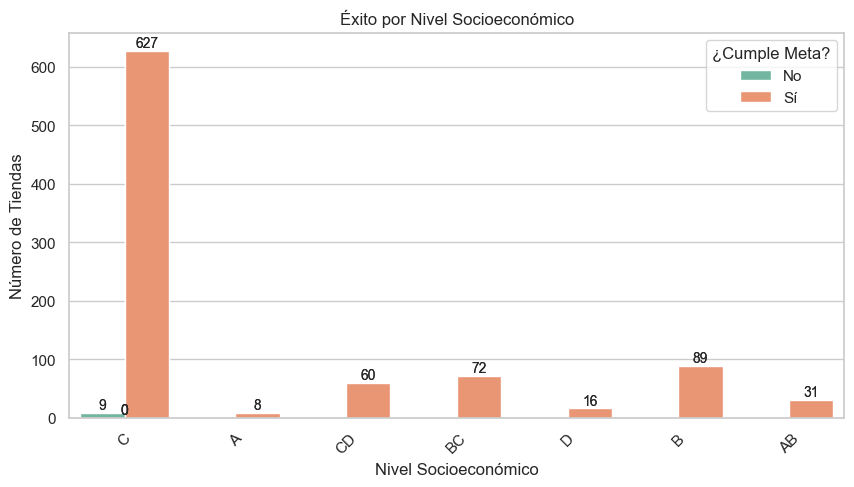

In [14]:
# Nivel Socioeconomico y exitos
plt.figure(figsize=(10,5))
sns.countplot(data=df_tiendas, x="NIVELSOCIOECONOMICO_DES", hue="EXITO", palette="Set2")
plt.title("Éxito por Nivel Socioeconómico")
plt.xticks(rotation=45)
plt.xlabel("Nivel Socioeconómico")
plt.ylabel("Número de Tiendas")
ax = sns.countplot(data=df_tiendas, x="NIVELSOCIOECONOMICO_DES", hue="EXITO", palette="Set2")
for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    ax.text(x + width / 2, height + 1, f"{int(height)}", ha='center', va='bottom', fontsize=10)
plt.legend(title="¿Cumple Meta?", labels=["No", "Sí"])
plt.show()

# La suma total de ventas por tienda


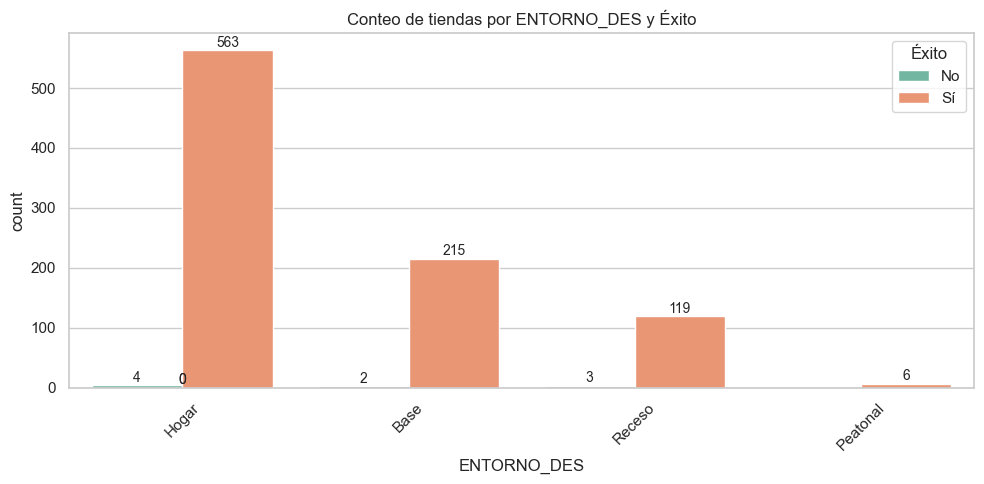

In [15]:
plt.figure(figsize=(10,5))
ax = sns.countplot(data=df_tiendas, x="ENTORNO_DES", hue="EXITO", palette="Set2")
plt.title("Conteo de tiendas por ENTORNO_DES y Éxito")
plt.xticks(rotation=45)
plt.legend(title="Éxito", labels=["No", "Sí"])

for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    ax.text(x + width / 2, height + 1, f"{int(height)}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


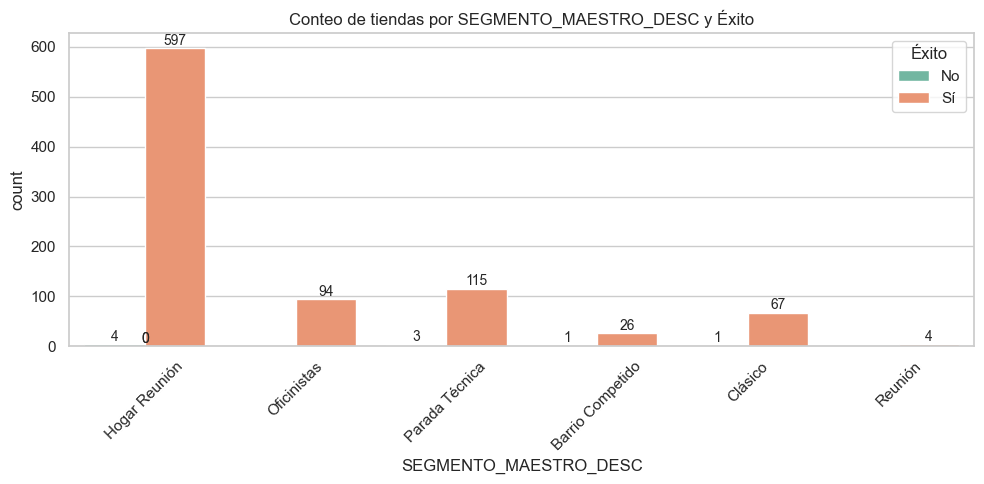

In [16]:
plt.figure(figsize=(10,5))
ax = sns.countplot(data=df_tiendas, x="SEGMENTO_MAESTRO_DESC", hue="EXITO", palette="Set2")
plt.title("Conteo de tiendas por SEGMENTO_MAESTRO_DESC y Éxito")
plt.xticks(rotation=45)
plt.legend(title="Éxito", labels=["No", "Sí"])

for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    ax.text(x + width / 2, height + 1, f"{int(height)}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

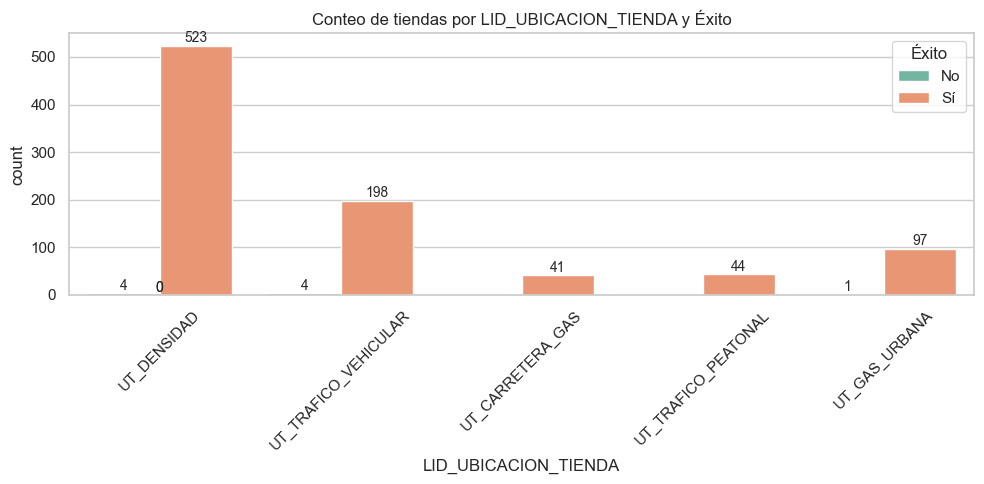

In [17]:
plt.figure(figsize=(10,5))
ax = sns.countplot(data=df_tiendas, x="LID_UBICACION_TIENDA", hue="EXITO", palette="Set2")
plt.title("Conteo de tiendas por LID_UBICACION_TIENDA y Éxito")
plt.xticks(rotation=45)
plt.legend(title="Éxito", labels=["No", "Sí"])

for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    ax.text(x + width / 2, height + 1, f"{int(height)}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

<Axes: xlabel='MTS2VENTAS_NUM', ylabel='Density'>

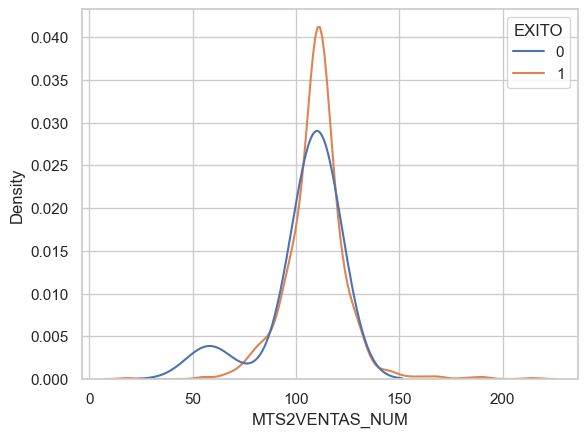

In [18]:
sns.kdeplot(data=df_tiendas, x="MTS2VENTAS_NUM", hue="EXITO", common_norm=False)


<Axes: xlabel='CAJONESESTACIONAMIENTO_NUM', ylabel='Density'>

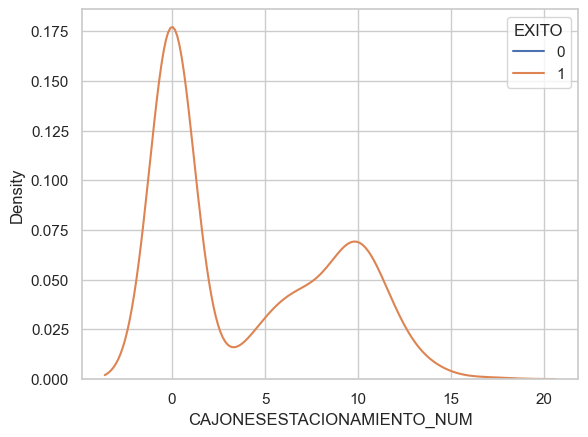

In [19]:
sns.kdeplot(data=df_tiendas, x="CAJONESESTACIONAMIENTO_NUM", hue="EXITO", common_norm=False)

<Axes: xlabel='PUERTASREFRIG_NUM', ylabel='Density'>

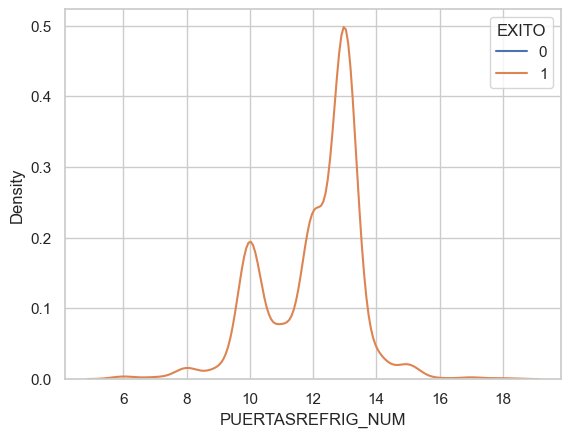

In [20]:
sns.kdeplot(data=df_tiendas, x="PUERTASREFRIG_NUM", hue="EXITO", common_norm=False)

### Proporcion sankey

In [21]:
# Data
df_sankey = df_tiendas[[
    "NIVELSOCIOECONOMICO_DES",
    "ENTORNO_DES",
    "SEGMENTO_MAESTRO_DESC",
    "LID_UBICACION_TIENDA",
    "EXITO"
]].copy()

In [22]:
# Mapear EXITO a texto
df_sankey["EXITO"] = df_sankey["EXITO"].map({0: "No Exitoso", 1: "Exitoso"})

In [23]:
# Lista única de etiquetas
labels = pd.concat([
    df_sankey["NIVELSOCIOECONOMICO_DES"],
    df_sankey["ENTORNO_DES"],
    df_sankey["SEGMENTO_MAESTRO_DESC"],
    df_sankey["LID_UBICACION_TIENDA"],
    df_sankey["EXITO"]
]).unique().tolist()

In [24]:
# Función para obtener índice
def get_index(label):
    return labels.index(label)

In [25]:
# Total para porcentaje
total = len(df_sankey)

In [26]:
# Flujos entre columnas
def make_links(source_col, target_col):
    group = df_sankey.groupby([source_col, target_col]).size().reset_index(name='count')
    group["percentage"] = group["count"] / total * 100
    group["label"] = group.apply(lambda row: f"{row['count']} tiendas ({row['percentage']:.1f}%)", axis=1)
    sources = group[source_col].apply(get_index).tolist()
    targets = group[target_col].apply(get_index).tolist()
    values = group["count"].tolist()
    labels_hover = group["label"].tolist()
    return sources, targets, values, labels_hover

In [27]:
# Generar los datos para cada nivel
s1, t1, v1, l1 = make_links("NIVELSOCIOECONOMICO_DES", "ENTORNO_DES")
s2, t2, v2, l2 = make_links("ENTORNO_DES", "SEGMENTO_MAESTRO_DESC")
s3, t3, v3, l3 = make_links("SEGMENTO_MAESTRO_DESC", "LID_UBICACION_TIENDA")
s4, t4, v4, l4 = make_links("LID_UBICACION_TIENDA", "EXITO")

In [28]:
# Unir todo
sources = s1 + s2 + s3 + s4
targets = t1 + t2 + t3 + t4
values = v1 + v2 + v3 + v4
hover_labels = l1 + l2 + l3 + l4

In [29]:
# Crear Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        label=labels,
        color="lightblue"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        label=hover_labels,
        customdata=hover_labels,
        hovertemplate='<b>%{customdata}</b><extra></extra>'
    ))])

In [30]:

fig.update_layout(title_text="Sankey Multinivel con Conteo y Porcentaje de Tiendas", font_size=10)
fig.show()


# Limpieza de datos

In [31]:
# Mt2 = 0
media_mt2 = df.loc[df["MTS2VENTAS_NUM"] > 0, "MTS2VENTAS_NUM"].mean()
df.loc[df["MTS2VENTAS_NUM"] == 0, "MTS2VENTAS_NUM"] = media_mt2

In [32]:
# Refris = 0
df["PUERTASREFRIG_NUM"] = df.groupby(
    ["ENTORNO_DES", "SEGMENTO_MAESTRO_DESC"]
)["PUERTASREFRIG_NUM"].transform(
    lambda x: x.replace(0, x[x > 0].mean())
)

In [33]:
# NULL BUSTING 
df_clean = df.dropna()

In [34]:
df_clean.isnull().sum()

TIENDA_ID                     0
MES_ID                        0
VENTA_TOTAL                   0
PLAZA_CVE                     0
NIVELSOCIOECONOMICO_DES       0
ENTORNO_DES                   0
MTS2VENTAS_NUM                0
PUERTASREFRIG_NUM             0
CAJONESESTACIONAMIENTO_NUM    0
LATITUD_NUM                   0
LONGITUD_NUM                  0
SEGMENTO_MAESTRO_DESC         0
LID_UBICACION_TIENDA          0
DATASET                       0
Meta_venta                    0
EXITO                         0
POBTOT                        0
TOTHOG                        0
POCUPADA                      0
PDESOCUP                      0
P_18A24                       0
P_18A24_F                     0
P_18A24_M                     0
VPH_REFRI                     0
VPH_AUTOM                     0
VPH_PC                        0
VPH_NDACMM                    0
VPH_SINCINT                   0
P_12YMAS                      0
P_15YMAS                      0
P_15A49_F                     0
POB15_64

In [35]:
df_clean

,TIENDA_ID,MES_ID,VENTA_TOTAL,PLAZA_CVE,NIVELSOCIOECONOMICO_DES,ENTORNO_DES,MTS2VENTAS_NUM,PUERTASREFRIG_NUM,CAJONESESTACIONAMIENTO_NUM,LATITUD_NUM,...,POB15_64,PEA,PE_INAC,P12YM_CASA,P12YM_SOLT,P15YM_AN,P15YM_SE,P15PRI_CO,P15SEC_CO,P18YM_PB
0,813,202404,1042761.16,2.0,C,Hogar,108.360000,12.0,0.0,25.99200,...,2162.0,1553.0,1069.0,1292.0,864.0,82.0,131.0,433.0,626.0,835.0
1,436,202404,2486787.81,3.0,BC,Hogar,111.437652,13.0,0.0,25.54982,...,904.0,644.0,359.0,606.0,339.0,12.0,13.0,56.0,181.0,615.0
2,732,202404,680701.78,5.0,C,Hogar,118.460000,15.0,0.0,25.75866,...,7080.0,5378.0,2102.0,5192.0,1892.0,31.0,33.0,441.0,2772.0,3370.0
3,282,202404,1227768.82,6.0,BC,Receso,114.000000,13.0,0.0,24.85018,...,2298.0,1516.0,1551.0,1586.0,1047.0,46.0,57.0,331.0,546.0,1441.0
4,704,202404,1052094.97,1.0,C,Base,107.230000,13.0,0.0,25.68419,...,3258.0,2376.0,1844.0,1954.0,1522.0,85.0,121.0,483.0,1062.0,1792.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18569,233,202312,395789.12,4.0,C,Base,102.970000,13.0,10.0,25.66750,...,6716.0,4924.0,3120.0,4188.0,2749.0,117.0,186.0,863.0,2079.0,3521.0
18570,539,202312,1413451.87,6.0,B,Base,114.815000,13.0,0.0,25.69036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18571,885,202312,1157010.83,2.0,B,Receso,110.150000,10.0,9.0,25.98226,...,968.0,749.0,592.0,666.0,404.0,8.0,3.0,101.0,96.0,939.0
18572,793,202401,699916.91,6.0,C,Base,109.400000,13.0,0.0,25.19030,...,1635.0,1241.0,933.0,1022.0,721.0,47.0,108.0,250.0,499.0,839.0


# Exploracion

## Mapa

In [36]:
# Inicializar el mapa y el cluster
mapa = folium.Map(location=[df_clean["LATITUD_NUM"].mean(), df_clean["LONGITUD_NUM"].mean()], zoom_start=6)
marker_cluster = MarkerCluster().add_to(mapa)

In [37]:
# Coordenadas
coordenadas_agregadas = set()

In [38]:
# Mapear
for _, row in df_clean.iterrows():
    coord = (row["LATITUD_NUM"], row["LONGITUD_NUM"])
    
    if coord in coordenadas_agregadas:
        continue  

    coordenadas_agregadas.add(coord)
    
    color = "green" if row["EXITO"] == 1 else "red"
    folium.CircleMarker(
        location=[row["LATITUD_NUM"], row["LONGITUD_NUM"]],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Tienda: {row['TIENDA_ID']}",
    ).add_to(marker_cluster)

In [39]:
# Mostrar mapa
mapa


# Modelo?

## Base

In [40]:
# Separar columnas numéricas y no numéricas en el df original
cols_num = df.select_dtypes(include=['number']).columns.tolist()
cols_cat = df.select_dtypes(exclude=['number']).columns.tolist()

# Quitamos 'TIENDA_ID' de las listas para no agregarla
if 'TIENDA_ID' in cols_num:
    cols_num.remove('TIENDA_ID')
if 'TIENDA_ID' in cols_cat:
    cols_cat.remove('TIENDA_ID')

# Armamos el diccionario para el agg automático
agg_dict = {}

# Para numéricas, usar promedio
for col in cols_num:
    agg_dict[col] = 'mean'

# Para categóricas, usar el primer valor que aparece (podrías cambiarlo si quieres otro criterio)
for col in cols_cat:
    agg_dict[col] = 'first'

# Groupby y agregación automática
df_tiendas = df.groupby('TIENDA_ID', as_index=False).agg(agg_dict)

# Ahora puedes agregar columnas derivadas como 'EXITO' y 'PCT_CUMPLIMIENTO'
df_tiendas['EXITO'] = (df_tiendas['VENTA_TOTAL'] >= df_tiendas['Meta_venta']).astype(int)
df_tiendas['PCT_CUMPLIMIENTO'] = df_tiendas['VENTA_TOTAL'] / df_tiendas['Meta_venta'] * 100


In [41]:
df_tiendas

,TIENDA_ID,MES_ID,VENTA_TOTAL,PLAZA_CVE,MTS2VENTAS_NUM,PUERTASREFRIG_NUM,CAJONESESTACIONAMIENTO_NUM,LATITUD_NUM,LONGITUD_NUM,Meta_venta,...,P15YM_SE,P15PRI_CO,P15SEC_CO,P18YM_PB,NIVELSOCIOECONOMICO_DES,ENTORNO_DES,SEGMENTO_MAESTRO_DESC,LID_UBICACION_TIENDA,DATASET,PCT_CUMPLIMIENTO
0,1,202349.0,7.080276e+05,2.0,111.750000,13.0,0.0,26.00177,-98.24284,490000.0,...,151.0,1088.0,2956.0,3004.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,TRAIN,144.495422
1,2,202349.0,8.994741e+05,2.0,111.750000,13.0,0.0,26.04198,-98.35620,490000.0,...,88.0,962.0,2626.0,7120.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,TRAIN,183.566149
2,3,202349.0,8.274871e+05,2.0,111.750000,13.0,0.0,26.02464,-98.26098,490000.0,...,158.0,512.0,1109.0,1221.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,TRAIN,168.874920
3,4,202349.0,1.247370e+06,2.0,109.114882,13.0,0.0,26.04326,-98.23851,490000.0,...,304.0,1218.0,2802.0,3062.0,A,Hogar,Hogar Reunión,UT_DENSIDAD,TRAIN,254.565345
4,5,202349.0,1.596267e+06,2.0,113.984172,12.0,0.0,26.06397,-98.26165,490000.0,...,60.0,426.0,645.0,1073.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,TRAIN,325.768674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,1052,202349.0,1.136733e+06,2.0,110.810000,11.0,0.0,26.06517,-98.34480,480000.0,...,0.0,54.0,130.0,1235.0,B,Base,Parada Técnica,UT_DENSIDAD,TRAIN,236.819417
908,1053,202349.0,7.660571e+05,2.0,111.750000,13.0,0.0,26.04132,-98.29259,490000.0,...,107.0,472.0,767.0,1119.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,TRAIN,156.338190
909,1054,202349.0,1.561485e+06,2.0,109.732783,12.0,0.0,26.09605,-98.29327,490000.0,...,232.0,1367.0,1565.0,1185.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,TRAIN,318.670388
910,1055,202349.0,1.014392e+06,2.0,111.750000,13.0,0.0,26.01132,-98.38140,490000.0,...,133.0,757.0,1663.0,1531.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,TRAIN,207.018841


In [42]:
# Mt2 = 0
media_mt2 = df_tiendas.loc[df_tiendas["MTS2VENTAS_NUM"] > 0, "MTS2VENTAS_NUM"].mean()
df_tiendas.loc[df_tiendas["MTS2VENTAS_NUM"] == 0, "MTS2VENTAS_NUM"] = media_mt2

In [43]:
# Refris = 0
df_tiendas["PUERTASREFRIG_NUM"] = df_tiendas.groupby(
    ["ENTORNO_DES", "SEGMENTO_MAESTRO_DESC"]
)["PUERTASREFRIG_NUM"].transform(
    lambda x: x.replace(0, x[x > 0].mean())
)

In [44]:
# NULL BUSTING 
df_clean = df_tiendas.dropna()

In [45]:
df_clean.isnull().sum()

TIENDA_ID                     0
MES_ID                        0
VENTA_TOTAL                   0
PLAZA_CVE                     0
MTS2VENTAS_NUM                0
PUERTASREFRIG_NUM             0
CAJONESESTACIONAMIENTO_NUM    0
LATITUD_NUM                   0
LONGITUD_NUM                  0
Meta_venta                    0
EXITO                         0
POBTOT                        0
TOTHOG                        0
POCUPADA                      0
PDESOCUP                      0
P_18A24                       0
P_18A24_F                     0
P_18A24_M                     0
VPH_REFRI                     0
VPH_AUTOM                     0
VPH_PC                        0
VPH_NDACMM                    0
VPH_SINCINT                   0
P_12YMAS                      0
P_15YMAS                      0
P_15A49_F                     0
POB15_64                      0
PEA                           0
PE_INAC                       0
P12YM_CASA                    0
P12YM_SOLT                    0
P15YM_AN

In [46]:
df_clean

,TIENDA_ID,MES_ID,VENTA_TOTAL,PLAZA_CVE,MTS2VENTAS_NUM,PUERTASREFRIG_NUM,CAJONESESTACIONAMIENTO_NUM,LATITUD_NUM,LONGITUD_NUM,Meta_venta,...,P15YM_SE,P15PRI_CO,P15SEC_CO,P18YM_PB,NIVELSOCIOECONOMICO_DES,ENTORNO_DES,SEGMENTO_MAESTRO_DESC,LID_UBICACION_TIENDA,DATASET,PCT_CUMPLIMIENTO
0,1,202349.0,7.080276e+05,2.0,111.750000,13.0,0.0,26.00177,-98.24284,490000.0,...,151.0,1088.0,2956.0,3004.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,TRAIN,144.495422
1,2,202349.0,8.994741e+05,2.0,111.750000,13.0,0.0,26.04198,-98.35620,490000.0,...,88.0,962.0,2626.0,7120.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,TRAIN,183.566149
2,3,202349.0,8.274871e+05,2.0,111.750000,13.0,0.0,26.02464,-98.26098,490000.0,...,158.0,512.0,1109.0,1221.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,TRAIN,168.874920
3,4,202349.0,1.247370e+06,2.0,109.114882,13.0,0.0,26.04326,-98.23851,490000.0,...,304.0,1218.0,2802.0,3062.0,A,Hogar,Hogar Reunión,UT_DENSIDAD,TRAIN,254.565345
4,5,202349.0,1.596267e+06,2.0,113.984172,12.0,0.0,26.06397,-98.26165,490000.0,...,60.0,426.0,645.0,1073.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,TRAIN,325.768674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,1052,202349.0,1.136733e+06,2.0,110.810000,11.0,0.0,26.06517,-98.34480,480000.0,...,0.0,54.0,130.0,1235.0,B,Base,Parada Técnica,UT_DENSIDAD,TRAIN,236.819417
908,1053,202349.0,7.660571e+05,2.0,111.750000,13.0,0.0,26.04132,-98.29259,490000.0,...,107.0,472.0,767.0,1119.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,TRAIN,156.338190
909,1054,202349.0,1.561485e+06,2.0,109.732783,12.0,0.0,26.09605,-98.29327,490000.0,...,232.0,1367.0,1565.0,1185.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,TRAIN,318.670388
910,1055,202349.0,1.014392e+06,2.0,111.750000,13.0,0.0,26.01132,-98.38140,490000.0,...,133.0,757.0,1663.0,1531.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,TRAIN,207.018841


In [47]:
df_clean.to_csv('df_clean.csv', index=False)

## Prediccion normalita

In [48]:
# Funcion de distancia Haversine

def haversine(lat1, lon1, lat2, lon2):
    # Radio de la Tierra en kilómetros
    R = 6371  

    # Convierto tooooooodas las coordenadas de grados a radianes (porque las funciones trigonométricas usan radianes)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Calculo la diferencia entre las latitudes y longitudes
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Fórmula de Haversine: calculo la distancia entre dos puntos en una esfera (asumiendo una Tierra esférica, right?)
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # Multiplico por el radio de la Tierra para convertir la distancia angular a kilómetros
    return R * c



In [49]:
ruta_tif = "/Users/abigail/Desktop/SEM VIII/DSC/Data/mex_ppp_2020_UNadj.tif"
import rasterio
from rasterio.warp import transform


# Abres el raster UNA sola vez (por ejemplo, al inicio del script)
src_raster = rasterio.open(ruta_tif)

def zona_habitable(lat, lon, umbral=1):
    bounds = src_raster.bounds
    if not (bounds.left <= lon <= bounds.right and bounds.bottom <= lat <= bounds.top):
        return False

    row, col = src_raster.index(lon, lat)  # lon primero
    valor = src_raster.read(1)[row, col]
    return valor >= umbral




In [50]:
# Ruta 
ruta_shapefile = "/Users/abigail/Desktop/SEM VIII/DSC/Data/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp"

# Cargar el shapefile
gdf = gpd.read_file(ruta_shapefile)

# Filtrar sólo México
mexico = gdf[gdf['admin'] == 'Mexico']

def esta_en_mexico(lat, lon):
    # shapely usa (lon, lat)
    punto = Point(lon, lat)  
    return mexico.contains(punto).any()


In [51]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from imblearn.combine import SMOTETomek
import shap
def entrenar_modelo(df):
    # Define columnas categóricas y numéricas
    cat_cols = [
        "PLAZA_CVE", "NIVELSOCIOECONOMICO_DES", "ENTORNO_DES",
        "SEGMENTO_MAESTRO_DESC", "LID_UBICACION_TIENDA"
    ]

    num_cols = [
        "MTS2VENTAS_NUM", "PUERTASREFRIG_NUM", "CAJONESESTACIONAMIENTO_NUM",
        "LATITUD_NUM", "LONGITUD_NUM",
        'POBTOT', 'TOTHOG', 'POCUPADA', 'PDESOCUP', 'P_18A24', 'P_18A24_F', 'P_18A24_M',
        'VPH_REFRI', 'VPH_AUTOM', 'VPH_PC', 'VPH_NDACMM', 'VPH_SINCINT',
        'P_12YMAS', 'P_15YMAS', 'P_15A49_F', 'POB15_64', 'PEA', 'PE_INAC', 'P12YM_CASA',
        'P12YM_SOLT', 'P15YM_AN', 'P15YM_SE', 'P15PRI_CO', 'P15SEC_CO', 'P18YM_PB'
    ]

    # Drop NAs
    df = df.dropna(subset=cat_cols + num_cols + ['EXITO'])

    # Separar features y target
    X_cat = df[cat_cols]
    X_num = df[num_cols]
    y = df['EXITO']

    # One-hot encoding
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
    X_cat_encoded = encoder.fit_transform(X_cat)
    X_cat_df = pd.DataFrame(X_cat_encoded, columns=encoder.get_feature_names_out(cat_cols), index=df.index)

    # Combinar features
    X = pd.concat([X_num, X_cat_df], axis=1)

    # Split estratificado
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # Aplicar SMOTETomek
    smt = SMOTETomek(random_state=42)
    X_train_bal, y_train_bal = smt.fit_resample(X_train, y_train)

    print(f"Balance después de SMOTETomek: {pd.Series(y_train_bal).value_counts().to_dict()}")

    # Grid Search
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    xgb = XGBClassifier(eval_metric='logloss', random_state=42)

    grid_search = GridSearchCV(xgb, param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=0)
    grid_search.fit(X_train_bal, y_train_bal)

    best_model = grid_search.best_estimator_

    # Evaluación
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Reporte clasificación:\n", classification_report(y_test, y_pred))
    print(f"Accuracy en test set: {acc:.4f}")
    print(f"F1 Score en test set: {f1:.4f}")


    # Aquí calculamos SHAP values para el set de entrenamiento balanceado
    explainer = shap.Explainer(best_model)
    shap_values = explainer(X_train_bal)

    # Calculamos la importancia global: promedio absoluto de SHAP values por feature
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    # Creamos lista con (feature, importancia) y ordenamos descendente
    feature_importance = sorted(zip(X_train_bal.columns, mean_abs_shap), key=lambda x: x[1], reverse=True)

    return best_model, encoder, cat_cols, num_cols, feature_importance


In [52]:
def predecir_tienda_nueva(nueva_tienda, model, encoder, cat_cols, num_cols):
    # Armo un DataFrame con los datos que el usuario me da (la nueva tienda)
    nueva_df = pd.DataFrame([nueva_tienda])
    
    # Codifico las columnas categóricas con el encoder que ya entrenamos (para que el modelo entienda)
    cat_encoded = encoder.transform(nueva_df[cat_cols])
    
    # Transformo esa codificación en un DataFrame para poder combinarlo fácil con los numéricos
    cat_encoded_df = pd.DataFrame(cat_encoded, columns=encoder.get_feature_names_out(cat_cols), index=nueva_df.index)

    # Junto las columnas numéricas originales con las columnas categóricas codificadas
    X_new = pd.concat([nueva_df[num_cols], cat_encoded_df], axis=1)
    
    # Verifico que todas las columnas que espera el modelo estén en X_new, si falta alguna la lleno con ceros
    #    Esto pasa porque el encoder puede crear más columnas que no estaban en la nueva tienda (categorías que no tiene)
    for col in model.get_booster().feature_names:
        if col not in X_new.columns:
            X_new[col] = 0
            
    # Reordeno las columnas para que coincidan exactamente con el orden que espera el modelo (muy importante)
    X_new = X_new[model.get_booster().feature_names]
    
    # Hago la predicción: pred es la clase (éxito o no éxito)
    pred = model.predict(X_new)[0]
    
    # Obtengo la probabilidad de que sea éxito (la clase 1), para tener un “porcentaje” de confianza
    prob = model.predict_proba(X_new)[0][1]
    
    # Devuelvo la predicción y la probabilidad para que el que llamó la función decida qué hacer
    return pred, prob


In [53]:
# Primero entreno el modelo y tomo el codificador y las columnas que necesito
modelo, codificador, cat_cols, num_cols, importancia_shap = entrenar_modelo(df)

for feat, imp in importancia_shap:
    print(f"{feat}: {imp:.5f}")


# Copio el DataFrame COMPLETO Y ORIGINAL limpio para usarlo sin arruinar el original
df_features = df_clean.copy()

# Creo un modelo de vecinos más cercanos, para encontrar la tienda más cercana. El vecino mas cercano (1)
knn = NearestNeighbors(n_neighbors=1)  
# Entreno el knn usando las coordenadas latitud y longitud de las tiendas
knn.fit(df_features[["LATITUD_NUM", "LONGITUD_NUM"]])

Balance después de SMOTETomek: {1: 13809, 0: 13809}
Reporte clasificación:
               precision    recall  f1-score   support

           0       0.38      0.51      0.43       263
           1       0.96      0.94      0.95      3452

    accuracy                           0.91      3715
   macro avg       0.67      0.72      0.69      3715
weighted avg       0.92      0.91      0.91      3715

Accuracy en test set: 0.9061
F1 Score en test set: 0.9488
CAJONESESTACIONAMIENTO_NUM: 0.36990
NIVELSOCIOECONOMICO_DES_C: 0.27152
ENTORNO_DES_Hogar: 0.20598
PUERTASREFRIG_NUM: 0.19570
SEGMENTO_MAESTRO_DESC_Hogar Reunión: 0.16379
LID_UBICACION_TIENDA_UT_GAS_URBANA: 0.15404
LATITUD_NUM: 0.14768
LONGITUD_NUM: 0.14488
MTS2VENTAS_NUM: 0.12516
P12YM_SOLT: 0.12513
PLAZA_CVE_4.0: 0.10351
PLAZA_CVE_3.0: 0.09682
VPH_NDACMM: 0.09465
NIVELSOCIOECONOMICO_DES_B: 0.08965
P15YM_SE: 0.08649
ENTORNO_DES_Receso: 0.06923
VPH_AUTOM: 0.06597
ENTORNO_DES_Base: 0.06458
LID_UBICACION_TIENDA_UT_TRAFICO_VEHICULAR: 0.0

NearestNeighbors(n_neighbors=1)

In [54]:
# Función que recibe una nueva latitud y longitud para predecir si abrir una tienda en esa ubicación sería exitoso
def predecir_con_coordenadas(lat, lon, df_features, knn, modelo, codificador, cat_cols, num_cols):

    # Encuentra indices y distancias de las 3 tiendas más cercanas (mejor que solo 1)
    distancias, indices = knn.kneighbors([[lat, lon]], n_neighbors=3)
    
    # Promedio ponderado simple inverso a la distancia para variables numéricas
    pesos = 1 / (distancias[0] + 1e-5)  # evitar div por cero
    pesos /= pesos.sum()

    # Variables categóricas (solo de la tienda más cercana, asumimos no cambian mucho)
    tienda_cercana = df_features.iloc[indices[0][0]]
    nueva_tienda = {col: tienda_cercana[col] for col in cat_cols}

    # Variables numéricas se promedian ponderadas entre las 3 tiendas más cercanas
    for col in num_cols:
        vals = df_features.iloc[indices[0]][col].values
        nueva_tienda[col] = (vals * pesos).sum()
    
    # Sobreescribir latitud y longitud con las que quiere evaluar el usuario
    nueva_tienda["LATITUD_NUM"] = lat
    nueva_tienda["LONGITUD_NUM"] = lon

    # Predice con la tienda "simulada"
    return predecir_tienda_nueva(nueva_tienda, modelo, codificador, cat_cols, num_cols)



# Optimizacion

In [55]:
def ventas_estimadas_con_ubicacion(x, modelo, base_tienda, encoder, cat_cols, num_cols):

    # Hago una copia de la tienda base para no modificar el original
    tienda = base_tienda.copy()

    # Le asigno a la tienda los valores nuevos que quiero probar (los que el optimizador me dice)
    tienda["MTS2VENTAS_NUM"] = x[0]
    tienda["PUERTASREFRIG_NUM"] = x[1]
    tienda["CAJONESESTACIONAMIENTO_NUM"] = x[2]

    # Uso mi función que ya predice para tiendas nuevas, así que la aprovecho
    _, prob = predecir_tienda_nueva(tienda, modelo, encoder, cat_cols, num_cols)

    # Como la función de optimización (minimize) busca minimizar, yo regreso el negativo de la probabilidad para que internamente se maximice la probabilidad de éxito
    return -prob


In [56]:
ENTORNOS_VALIDOS = {"Base", "Hogar", "Peatonal", "Receso"}

def armar_input_tienda(row, entorno, lat, lon, cat_cols, num_cols):
    """Crea el diccionario input para el modelo desde un DataFrame row."""
    tienda = {col: row[col] for col in cat_cols if col != "ENTORNO_DES"}  
    tienda["ENTORNO_DES"] = entorno  

    for col in num_cols:
        tienda[col] = row[col]
    
    tienda["LATITUD_NUM"] = lat
    tienda["LONGITUD_NUM"] = lon
    return tienda

def predecir_y_optimizar_con_recomendacion(lat, lon, entorno, radio_km=5):
    try:
        if entorno not in ENTORNOS_VALIDOS:
            raise ValueError(f"Entorno '{entorno}' no válido. Debe ser uno de {ENTORNOS_VALIDOS}")

        if not esta_en_mexico(lat, lon):
            raise ValueError("Ubicación fuera de México, no se puede hacer predicción.")

        if not zona_habitable(lat, lon):
            print("Controlado: La ubicación está en zona NO habitable (montañas, lagos, bosques, etc.)")
            return None

        # Busco la tienda más cercana
        _, idx = knn.kneighbors([[lat, lon]])
        tienda_cercana = df_features.iloc[idx[0][0]]

        base_tienda = armar_input_tienda(tienda_cercana, entorno, lat, lon, cat_cols, num_cols)

        # Valores iniciales para optimizar (puedes ajustar bounds)
        x0 = [base_tienda["MTS2VENTAS_NUM"], base_tienda["PUERTASREFRIG_NUM"], base_tienda["CAJONESESTACIONAMIENTO_NUM"]]
        bounds = [(50, 200), (1, 10), (0, 10)]

        resultado = minimize(
            ventas_estimadas_con_ubicacion,
            x0,
            args=(modelo, base_tienda, codificador, cat_cols, num_cols),
            bounds=bounds,
            method='L-BFGS-B'
        )

        if not resultado.success:
            print("La optimización no convergió. Usando parámetros base.")
            mts2_opt, puertas_opt, cajones_opt = x0
            prob_opt = None
        else:
            mts2_opt, puertas_opt, cajones_opt = resultado.x
            prob_opt = -resultado.fun

        pred_usuario, prob_init = predecir_tienda_nueva(base_tienda, modelo, codificador, cat_cols, num_cols)

        print("\n-- RESULTADO INICIAL --")
        print(f"Predicción: {'Éxito' if pred_usuario == 1 else 'No éxito'}")
        print(f"Probabilidad de éxito: {prob_init:.2%}")

        venta_real = tienda_cercana.get("VENTA_TOTAL", None)
        meta_real = tienda_cercana.get("Meta_venta", None)
        if venta_real is not None and meta_real is not None and meta_real != 0:
            diferencia = ((venta_real - meta_real) / meta_real) * 100
            if pred_usuario == 1:
                print(f"Las ventas mejorarían en aproximadamente {diferencia:.2f}%")
            else:
                print(f"Las ventas caerían por debajo de la meta en aproximadamente {abs(diferencia):.2f}%")

        print("\n-- RESULTADO OPTIMIZADO --")
        print(f"Mts2 óptimo: {mts2_opt:.2f}")
        print(f"Puertas refrigeración óptimo: {puertas_opt:.2f}")
        print(f"Cajones estacionamiento óptimo: {cajones_opt:.2f}")
        if prob_opt is not None:
            print(f"Probabilidad estimada de éxito optimizado: {prob_opt:.2%}")

        # Recomendar mejores ubicaciones en el radio
        df_tmp = df_features.copy()
        df_tmp["DISTANCIA"] = haversine(lat, lon, df_tmp["LATITUD_NUM"], df_tmp["LONGITUD_NUM"])
        vecinas = df_tmp[df_tmp["DISTANCIA"] <= radio_km]

        mejor_prob = prob_init
        mejor_ubicacion = (lat, lon, prob_init)

        for _, row in vecinas.iterrows():
            tienda = armar_input_tienda(row, entorno, row["LATITUD_NUM"], row["LONGITUD_NUM"], cat_cols, num_cols)
            _, prob = predecir_tienda_nueva(tienda, modelo, codificador, cat_cols, num_cols)
            if prob > mejor_prob + 0.05:
                mejor_prob = prob
                mejor_ubicacion = (row["LATITUD_NUM"], row["LONGITUD_NUM"], prob)

        if (mejor_ubicacion[0], mejor_ubicacion[1]) != (lat, lon):
            lat2, lon2, prob2 = mejor_ubicacion
            print("\n-- RECOMENDACIÓN --")
            print(f"Ubicación sugerida: ({lat2:.5f}, {lon2:.5f})")
            print(f"Probabilidad de éxito: {prob2:.2%} (+{(prob2 - prob_init):.2%})")
        else:
            print("\nLa ubicación actual es adecuada. No se encontró mejora significativa en un radio de 5km.")

        return {
            "Prediccion inicial": (pred_usuario, prob_init),
            "Resultado optimizado": (mts2_opt, puertas_opt, cajones_opt, prob_opt),
            "Recomendacion": mejor_ubicacion
        }

    except ValueError as e:
        print(f"Error controlado: {e}")
        return None





# P R U E B A

In [61]:
predecir_y_optimizar_con_recomendacion(25.69107, -100.21261, "Receso")


-- RESULTADO INICIAL --
Predicción: Éxito
Probabilidad de éxito: 88.67%
Las ventas mejorarían en aproximadamente 83.25%

-- RESULTADO OPTIMIZADO --
Mts2 óptimo: 127.42
Puertas refrigeración óptimo: 10.00
Cajones estacionamiento óptimo: 7.00
Probabilidad estimada de éxito optimizado: 88.55%

-- RECOMENDACIÓN --
Ubicación sugerida: (25.66474, -100.20913)
Probabilidad de éxito: 95.80% (+7.14%)


{'Prediccion inicial': (1, 0.8866543),
 'Resultado optimizado': (127.42, 10.0, 7.0, 0.88551515),
 'Recomendacion': (25.66474, -100.20912999999999, 0.95803523)}

# Test Data

In [58]:
Test_data = pd.read_csv("/Users/abigail/Desktop/SEM VIII/DSC/Data/DIM_TIENDA_TEST.csv")

In [ ]:
resultados = []

for idx, row in Test_data.iterrows():
    lat = row["LATITUD_NUM"]
    lon = row["LONGITUD_NUM"]
    entorno = row["ENTORNO_DES"]
    
    print(f"\n🔍 Evaluando tienda {row['TIENDA_ID']}...")

    try:
        resultado = predecir_y_optimizar_con_recomendacion(lat, lon, entorno)
        
        if resultado is None:
            resultados.append({
                "TIENDA_ID": row["TIENDA_ID"],
                "status": "Error en predicción",
                "pred_exito_inicial": None,
                "probabilidad_inicial": None,
                "probabilidad_optimizada": None,
                "pred_exito_optimizado": None,
                "recomendacion_lat": None,
                "recomendacion_lon": None,
                "recomendacion_prob": None
            })
        else:
            pred_inicial, prob_init = resultado["Prediccion inicial"]
            mts2, puertas, cajones, prob_opt = resultado["Resultado optimizado"]
            lat_rec, lon_rec, prob_rec = resultado["Recomendacion"]

            pred_opt = 1 if prob_opt and prob_opt >= 0.5 else 0  

            resultados.append({
                "TIENDA_ID": row["TIENDA_ID"],
                "status": "OK",
                "pred_exito_inicial": pred_inicial,
                "probabilidad_inicial": prob_init,
                "probabilidad_optimizada": prob_opt,
                "pred_exito_optimizado": pred_opt,
                "recomendacion_lat": lat_rec,
                "recomendacion_lon": lon_rec,
                "recomendacion_prob": prob_rec
            })

    except Exception as e:
        print(f"❌ Error con tienda {row['TIENDA_ID']}: {e}")
        resultados.append({
            "TIENDA_ID": row["TIENDA_ID"],
            "status": f"Excepción: {str(e)}",
            "pred_exito_inicial": None,
            "probabilidad_inicial": None,
            "probabilidad_optimizada": None,
            "pred_exito_optimizado": None,
            "recomendacion_lat": None,
            "recomendacion_lon": None,
            "recomendacion_prob": None
        })

# Convertir a DataFrame
df_resultados = pd.DataFrame(resultados)



🔍 Evaluando tienda 680...

-- RESULTADO INICIAL --
Predicción: Éxito
Probabilidad de éxito: 82.59%
Las ventas mejorarían en aproximadamente 171.18%

-- RESULTADO OPTIMIZADO --
Mts2 óptimo: 119.59
Puertas refrigeración óptimo: 10.00
Cajones estacionamiento óptimo: 0.00
Probabilidad estimada de éxito optimizado: 85.12%

-- RECOMENDACIÓN --
Ubicación sugerida: (25.66474, -100.20913)
Probabilidad de éxito: 94.29% (+11.70%)

🔍 Evaluando tienda 730...


KeyboardInterrupt: 

In [ ]:
df_resultados

,TIENDA_ID,status,pred_exito_inicial,probabilidad_inicial,probabilidad_optimizada,pred_exito_optimizado,recomendacion_lat,recomendacion_lon,recomendacion_prob
0,680,OK,1,0.825901,0.851157,1,25.66474,-100.20913,0.942943
1,730,OK,1,0.853957,0.911974,1,25.64782,-100.27427,0.992720
2,650,OK,1,0.609427,0.745962,1,25.64782,-100.27427,0.992720
3,670,OK,1,0.559514,0.559514,1,25.64220,-100.27802,0.961746
4,800,OK,1,0.920660,0.919832,1,25.67484,-100.24412,0.974237
...,...,...,...,...,...,...,...,...,...
100,720,OK,1,0.647315,0.767396,1,25.58452,-100.00093,0.927067
101,130,OK,0,0.483902,0.634710,1,25.37839,-100.11195,0.952486
102,320,OK,1,0.926197,0.926197,1,25.57214,-100.01371,0.926197
103,510,OK,1,0.914033,0.854666,1,25.19747,-99.83198,0.914033
